# Recurrent Neural Networks (RNN) and LSTMs

In this notebook, we will create a RNN model (with LSTM cells) that is able to speak like Freddy Mercury!

This notebook was inspired by:
* [A Beginner’s Guide on Recurrent Neural Networks with PyTorch](https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/), by Gabriel Loye.

* [Writing like Shakespeare with ML in Pytorch](https://towardsdatascience.com/writing-like-shakespeare-with-machine-learning-in-pytorch-d77f851d910c), by Albert Lai.

Do you need to learn more about RNNs before we start?
1. Read the [Illustrated Guide to Recurrent Neural Networks](https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9)
by Michael Nguyen
1. If you want to see a diagram of how a LSTM network looks from the inside, this [StackOverflow post](https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm) has a very clear picture.


## First step: download the dataset

1. Download the songlyrics dataset, by mousehead: https://www.kaggle.com/mousehead/songlyrics
2. Put the _songdata.csv_ file under our `data/` folder.

In [1]:
import pandas
import numpy as np
import re
import random
import datetime
import torch
from torch import nn
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mauricioaniche/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Let's read the CSV and get all the songs by Queen
all_songs = pandas.read_csv("data/songdata.csv")
queen_songs = all_songs[all_songs["artist"] == "Queen"]

## Pre processing

The first step is to process the lyrics, so that we can better feed it to the algorithms. Our next steps are:

1. Break each song into an array of strings.
1. Do some cleaning, e.g., trim, lower case, remove non ascii chars, etc. (Commented, you can see even some fancier NLP pre processing, such as stemming and stop word removal)
1. Create a set that contains all the words of the songs (our dictionary). We also attach each word a number. Technically speaking, it's nice to have two dictionaries, one that converts from int to word, and from word to int.
1. Define the length of the input. Usually, the inputs have a pre defined length. In here, we define as the length of the shortest song. In larger songs, we just "break them" in two, three, songs. The remaining sentences (the ones with less than 69 words) are discarded for now... But you can try to use it! More data!

In [3]:
# We extract all the words from the songs
def preprocessing(music):  
    
    words_in_a_song = music.split(" ")
    words_in_a_song = list(map(lambda x: x.strip(), words_in_a_song))
    words_in_a_song = list(map(lambda x: x.lower(), words_in_a_song))
    words_in_a_song = list(map(lambda x: re.sub(r'\W+', '', x), words_in_a_song))
    words_in_a_song = list(filter(lambda x: x is not '', words_in_a_song))
    #words_in_a_song = list(filter(lambda x: len(x) > 1, words_in_a_song))

    # maybe apply some traditional NLP here?
    #ps = PorterStemmer() 
    #stop_words = set(stopwords.words('english')) 
    #words_in_a_song = list(map(lambda x: ps.stem(x), words_in_a_song))
    #words_in_a_song = list(filter(lambda x: x not in stop_words, words_in_a_song))
    
    return words_in_a_song
    
# We add them all to a set, so we have a list of unique words
unique_words = set()
songs = list()
for index, row in queen_songs.iterrows():
    lyric = row["text"]
    words_in_a_song = preprocessing(lyric)
    if not words_in_a_song:
        continue

    songs.append(words_in_a_song)
    for word in words_in_a_song:
        unique_words.add(word)

In [4]:
# Let's map words to numbers
int_to_words = dict(enumerate(unique_words))
words_to_int = {v: k for k, v in int_to_words.items()}
print("We have {} songs and {} different words in our dictionary".format(len(songs), str(len(int_to_words))))

We have 163 songs and 3292 different words in our dictionary


In [5]:
int_to_words

{0: 'mystique',
 1: 'pile',
 2: 'nights',
 3: 'god',
 4: 'fantasy',
 5: 'tal',
 6: 'where',
 7: 'theyve',
 8: 'fried',
 9: 'fahrenheit',
 10: 'pound',
 11: 'painted',
 12: 'drip',
 13: 'at',
 14: 'abre',
 15: 'tai',
 16: 'knows',
 17: 'test',
 18: 'sore',
 19: 'caine',
 20: 'stings',
 21: 'guillotine',
 22: 'bed',
 23: 'tunnel',
 24: 'begged',
 25: 'trust',
 26: 'record',
 27: 'rule',
 28: 'affair',
 29: 'convinced',
 30: 'originally',
 31: 'cold',
 32: 'hills',
 33: 'extraordinarily',
 34: 'sweeping',
 35: 'plague',
 36: 'heat',
 37: 'cutest',
 38: 'living',
 39: 'midwifes',
 40: 'easy',
 41: 'spaces',
 42: 'torsos',
 43: 'dancing',
 44: 'wooo',
 45: 'pies',
 46: 'edge',
 47: 'unity',
 48: 'takes',
 49: 'mars',
 50: 'self',
 51: 'magic',
 52: 'pay',
 53: 'minding',
 54: 'attraction',
 55: 'sweet',
 56: 'shell',
 57: 'after',
 58: 'tolove',
 59: 'swine',
 60: 'upon',
 61: 'darkest',
 62: 'else',
 63: 'razzmatazz',
 64: 'petrified',
 65: 'each',
 66: 'lightning',
 67: 'beautiful',
 68: 

In [6]:
# We find the longest song, as we'll need this number to define the size of the ouput
longest_song = len(max(songs, key=len))
shortest_song = len(min(songs, key=len))
print("The longest song has {} words. Freddy was awesome, wasn't he?".format(longest_song))
print("The shortest song has {} words. Freddy was awesome, wasn't he?".format(shortest_song))

The longest song has 497 words. Freddy was awesome, wasn't he?
The shortest song has 69 words. Freddy was awesome, wasn't he?


Let's pad songs to the size of the shortest song. Larger songs will become 'two songs'!

In [7]:
# method extract from https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

song_chunks = list()
for song in songs:
    new_songs = list(chunks(song, shortest_song))
    for new_song in new_songs:
        song_chunks.append(new_song)
    
#songs = list(map(lambda x: x if len(x) <= shortest_song else x[:-(len(x) - shortest_song)], song_chunks))
songs = list(filter(lambda x: len(x) == shortest_song, song_chunks))
    
print("We now have {} 'songs'".format(len(songs)))

We now have 470 'songs'


## Training dataset

We should know create the training dataset. I'm dividing it in two parts: the `input` which contains the inputs to be trained, and the `target` that contains the ground truth, or, what the network should predict.

The idea here is for the network to predict the _last_ word of the sentence. So, in a sentence of 69 words, the input will contain the first 68 words, and the target will contain the 68 + the last word, the one that should be predicted. Note that we also remove the first word of the target, as we don't use it.

In [8]:
# Let's create inputs and ground truths
# The 'input' doesn't have the last word (as it will not be fed to the model)
# The 'target' is the music without the first word
input_seq = []
target_seq = []

for i in range(len(songs)):
    # Remove last character for input sequence
    input_seq.append(songs[i][:-1])
    
    # Remove firsts character for target sequence
    target_seq.append(songs[i][1:])
    print("Input Sequence: {}\nTarget Sequence: {}".format(input_seq[i], target_seq[i]))

Input Sequence: ['lets', 'go', 'steve', 'walks', 'warily', 'down', 'the', 'street', 'with', 'the', 'brim', 'pulled', 'way', 'down', 'low', 'aint', 'no', 'sound', 'but', 'the', 'sound', 'of', 'his', 'feet', 'machine', 'guns', 'ready', 'to', 'go', 'are', 'you', 'ready', 'are', 'you', 'ready', 'for', 'this', 'are', 'you', 'hanging', 'on', 'the', 'edge', 'of', 'your', 'seat', 'out', 'of', 'the', 'doorway', 'the', 'bullets', 'rip', 'to', 'the', 'sound', 'of', 'the', 'beat', 'chorus', 'another', 'one', 'bites', 'the', 'dust', 'another', 'one', 'bites']
Target Sequence: ['go', 'steve', 'walks', 'warily', 'down', 'the', 'street', 'with', 'the', 'brim', 'pulled', 'way', 'down', 'low', 'aint', 'no', 'sound', 'but', 'the', 'sound', 'of', 'his', 'feet', 'machine', 'guns', 'ready', 'to', 'go', 'are', 'you', 'ready', 'are', 'you', 'ready', 'for', 'this', 'are', 'you', 'hanging', 'on', 'the', 'edge', 'of', 'your', 'seat', 'out', 'of', 'the', 'doorway', 'the', 'bullets', 'rip', 'to', 'the', 'sound', '

In [9]:
# Let's convert the 'input' and the 'target' to numbers
for i in range(len(songs)):
    input_seq[i] = [words_to_int[w] for w in input_seq[i]]
    target_seq[i] = [words_to_int[w] for w in target_seq[i]]
    
print(input_seq)

[[2890, 1636, 2868, 566, 2488, 2791, 508, 1828, 2160, 508, 907, 3058, 131, 2791, 1615, 1787, 2959, 1019, 175, 508, 1019, 257, 813, 2656, 1948, 1752, 1012, 1958, 1636, 2638, 1587, 1012, 2638, 1587, 1012, 963, 974, 2638, 1587, 2845, 386, 508, 46, 257, 717, 1222, 702, 257, 508, 437, 508, 1136, 2378, 1958, 508, 1019, 257, 508, 1146, 2698, 3177, 2064, 1356, 508, 172, 3177, 2064, 1356], [172, 2219, 3177, 2064, 1033, 2219, 3177, 2064, 1033, 3177, 2064, 1356, 508, 172, 2018, 88, 1395, 2936, 1587, 165, 3177, 2064, 1356, 508, 172, 359, 1097, 1587, 223, 88, 1153, 1958, 2936, 1973, 1739, 1587, 191, 1398, 1033, 1587, 1557, 72, 963, 2954, 1145, 2499, 2155, 2219, 2789, 72, 702, 386, 1750, 2119, 2638, 1587, 1201, 2638, 1587, 479, 359, 2899, 1926, 1587, 1280, 508, 36, 702], [508, 437, 508, 1136, 2378, 1958, 508, 1019, 257, 508, 1146, 2698, 3177, 2064, 1356, 508, 172, 3177, 2064, 1356, 508, 172, 3177, 2064, 1356, 508, 172, 3177, 2064, 1356, 508, 172, 135, 2638, 3068, 257, 1375, 1587, 1926, 2668, 1330, 9

## Encoding

The model receives each word at a time as input. We know need to encode each of them. Let's do one hot encoding. The `one_hot_encode` method helps us in doing it.

In [10]:
dict_size = len(unique_words)
seq_len = shortest_song - 1
batch_size = len(songs) # all songs, not too many...

def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)
    
    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features

# One hot encode the input
input_seq_hot_encoded = one_hot_encode(input_seq, dict_size, seq_len, batch_size)
print("Input shape: {} --> (Batch Size, Sequence Length, One-Hot Encoding Size)".format(input_seq_hot_encoded.shape))

Input shape: (470, 68, 3292) --> (Batch Size, Sequence Length, One-Hot Encoding Size)


## Declaring the network

Next create a RNN network that contains LSTM cell(s), a dropout layer, and a fully-connected output layer. We shall call it the Freddie RNN.

Note how we define the output size as the number of words in our dictionary. Meaning, at the end, we want our network to give us the probability for each word to be the next one, so that we can pick the most probable one. 

The input is also as big as the input size, as we feed one hot encoded vector (which is as long as the number of words in the dictionary).

In [11]:
# Declaring the model
class FreddieRNN(nn.Module):
    
    def __init__(self, vocabulary_size, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers # number of LSTM layers
        self.n_hidden = n_hidden # number of features in the hidden layer
        self.lr = lr
        
        #define the LSTM with a droupout probability
        # the dropout layer might help the network to generalize!
        # Question: do we want this for Freddie, though? Or do we want Freddie to overfit real Freddie?
        self.lstm = nn.LSTM(vocabulary_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
                
        #define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, vocabulary_size)
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        #get the outputs and the new hidden state from the lstm
        # x has dimensions ([470, 68, 3292])
        out, hidden = self.lstm(x, hidden)
        
        # Out has dimensions [470, 68, 256]
        # Reshape the outputs such that it can be fit into the fully connected layer
        # After reshaping, [31960, 256]
        out = out.contiguous().view(-1, self.n_hidden)
        
        #put out through the fully-connected layer
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        hidden = (torch.zeros(self.n_layers, batch_size, self.n_hidden),
                  torch.zeros(self.n_layers, batch_size, self.n_hidden))
        
        return hidden

In [12]:
vocabulary_size = len(unique_words)

net = FreddieRNN(vocabulary_size)
print(net)

FreddieRNN(
  (lstm): LSTM(3292, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=3292, bias=True)
)


## Time to train it

As usual, let's define some hyper parameters, such as learning rate, optimizer and loss criterion. 

The training takes a long time in CPUs. See graphs above. If you are a GPU, change this code, and make Pytorch to burn your graphics video!

In [13]:
# hyperparameters
lr=0.001

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# storing the loss over time (for plotting purposes)
plot_y = []

# converting data to torch tensors
tensor_input_seq = torch.from_numpy(input_seq_hot_encoded)
tensor_target_seq = torch.Tensor(target_seq)

In [14]:
# let's train!
n_epochs = 5 # use a larger number in your machine!
for epoch in range(n_epochs):
    h = net.init_hidden(batch_size)
    
    net.zero_grad()
    
    output, h = net(tensor_input_seq, h)
    
    loss = criterion(output, tensor_target_seq.view(-1).long())
    
    print('epoch: ', epoch,' loss: ', loss.item())
    plot_y.append(loss.item())

    loss.backward()

    optimizer.step()

    # TODO: Read about the clip_grad_norm_ function. 
    # It helps in preventing the exploding gradient problem in RNNs / LSTMs.

epoch:  0  loss:  8.100645065307617
epoch:  1  loss:  8.086858749389648
epoch:  2  loss:  8.071735382080078
epoch:  3  loss:  8.051482200622559
epoch:  4  loss:  8.019065856933594


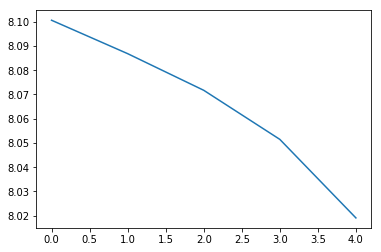

In [15]:
# The loss getting smaller and smaller over time
plt.plot(range(len(plot_y)), plot_y)

It took me around 16 hours to run ~5.3k epochs. Loss is 0.025066234171390533.

If you don't want to spend this time, load the model I saved.

In [21]:
# Let's save the model
#torch.save(net.state_dict(), "data/freddie.pth")

# Let's load the model
# net = FreddieRNN(input_size, output_size)
# net.load_state_dict(torch.load("data/freddie.pth"))

## Using the model

We are done training our Freddie RNN. It's time to use it. The idea is as follows:

1. The user gives an initial sentence as starting point and a total number of words s/he expects Freddie to write.
1. We give the user's initial words to the network.
1. Then, we predict the remaining N words.
1. Given that this is a prediction task, we need to convert our final layer to something that gives us probabilities, like Softmax. Softmax will transform the last layer in a set of probabilities (i.e., each neuron will have a probability of being the right one to be picked up, probabilities summing up to 1).
1. Given Freedy is a bit unpredictable, we get the top 5 (see `top_k` variable) most probable words, and pick one randomly. To make it funnier, we also make sure Freddy is not picking the same word as the last one.

In [17]:
top_k = 20
def predict(model, hidden, last_word):
    # One-hot encoding our input to fit into the model
    x = np.array([[words_to_int[last_word]]])
    x = one_hot_encode(x, dict_size, 1, 1) # seq-len=1, there's just one word here, batch=1, no need for batch..
    x = torch.from_numpy(x)
    
    out, hidden = model(x, hidden)
    
    # get the top K predictions, and randomly select one
    p = nn.functional.softmax(out, dim=1).data
    p, top = p.topk(top_k)
    
    while True:
        choice = random.randint(0, top_k-1)
        pred_word = top.data.numpy()[0][choice]

        # convert the int back to string
        pred_word_in_str = int_to_words[pred_word]
        if pred_word_in_str is not last_word:
            break
    
    return pred_word_in_str, hidden

In [18]:
def sing_freddy_sing(model, out_len, start):
    model.eval() # eval mode

    # First off, run through the starting words
    words = start.split(" ")
    size_left = out_len - len(words)
    
    h = net.init_hidden(1)
    for word in words:
        pred_word, h = predict(net, h, word)

    words.append(pred_word)
    
    # now, we run up to the size of the desired output
    for i in range(size_left):
        last_word = words[-1]
        word, h = predict(net, h, last_word)
        words.append(word)
    
    return ' '.join(words)

## Sing, Freddie, sing!

In [19]:
import pyttsx3
engine = pyttsx3.init()

In [24]:
seed_for_freddie = "under pressure in sun light"
freddie_sings = sing_freddy_sing(net, 30, seed_for_freddie)

print("Me: Freddie, can you sing me something, starting with '{}'".format(seed_for_freddie))
print()
print("Freddie Mercury: {}".format(freddie_sings))

engine.say(freddie_sings)
engine.runAndWait()

Me: Freddie, can you sing me something, starting with 'under pressure in sun light'

Freddie Mercury: under pressure in sun light they you lord bicycle take say take down hold you yeah say you the end lord end yourself got bicycle say take hold lord hold end


Freddy lives!